In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from easyocr import Reader
from difflib import SequenceMatcher

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
import imutils
import face_recognition
import time
import json

In [4]:
def init():
    readerLatin = Reader(["en"], gpu=True)
    readerArabic = Reader(["ar"], gpu=True)
    readermix = Reader(["ar","en"], gpu=True)
    return (readerLatin,readerArabic,readermix )

In [5]:
(readerLatin,readerArabic,readermix ) = init()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


NameError: name 'current' is not defined

In [6]:
def show(image1):
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image1)
    plt.title("image1")
    plt.axis('off')

In [7]:
def show2(im1,im2):
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(im1)
    plt.title("image1")
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(im2)
    plt.title("image1")
    plt.axis('off')

In [8]:
def drawROIs(image,boxes):
    im = image.copy()
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),2)
    return im

In [9]:
def traditional_processing(image,kw,kh):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kw, kh))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    gray = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(gray)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    return thresh

In [10]:
def traditional_ROI_extraction(image,kw,kh):
    image = traditional_processing(image,kw,kh)
    im_h,im_w = image.shape[:2]
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        (xstart,ystart,xend,yend)=(x,y,x+w,y+h)
        boxes.append((xstart,ystart,xend,yend))
    return boxes

In [11]:
def top_slash_coordinates(image,boxes,message):
    for box in boxes:
        (startX, startY, endX, endY) = box
        clip = image[startY:endY,startX:endX]
        try:
            text = readerLatin.readtext(clip)[0][1]
        except : 
            text ="."
        if SequenceMatcher(None, text, message).ratio()>0.7:
            return endY
    return 0

In [12]:
def face_coords(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb)
    m = 0
    main_face = face_locations[0]
    for face in face_locations:
        top, right, bottom, left = face
        area = abs(top - bottom) * abs(right - left)
        if area > m :
            m = area
            main_face = face
    leftX = main_face[1]
    bottom = main_face[2]
    return(leftX,bottom)

In [13]:
def close_up(image,message):
    height,width = image.shape[:2]
    (left,bottom) = face_coords(image)
    boxes = traditional_ROI_extraction(image,30,5)
    boxes = sorted(boxes,key=lambda x : x[1])
    up = top_slash_coordinates(image,boxes,message)
    image_closeup = image[up:bottom,left :width]
    return image_closeup

In [14]:
def clean_boxes(boxes,thresh):
    res = []
    for box in boxes:
        (startX, startY, endX, endY) = box
        area = abs(startX-endX) * abs(startY-endY)
        if area > thresh : 
            res.append(box)
    return res

In [15]:
def clear_labels(suggested_boxes,font_size):
    res = []
    for box in suggested_boxes:
        (startX, startY , endX, endY) = box
        Ysize = (endY - startY)
        if Ysize*1.0>(font_size*0.66):
            res.append(box)
    return res

In [16]:
images = ["testing.jpg","testing2.png"]
standard_font_ratio = 0.065

In [17]:
def extract_font_size(standard_font_ratio,image):
    height, width = image.shape[:2]
    f=standard_font_ratio * height
    return (f)

In [18]:
def process(image):
    width = 2200
    height = 1950
    image = close_up(image,"REPUBLIC OF TUNISIA")
    image = np.array(Image.fromarray(image).resize((width,height),resample=PIL.Image.BICUBIC))
    
    boxes = traditional_ROI_extraction(image,60,10)
    boxes = clean_boxes(boxes,4000)
    
    font_size = extract_font_size(standard_font_ratio,image)
    boxes = clear_labels(boxes,font_size)
    downy = max(boxes, key=lambda x:x[3])[3] 
    upy = min(boxes, key=lambda x:x[1])[1]
    leftx = min(boxes, key=lambda x:x[0])[0]
    rightx = max(boxes, key=lambda x:x[2])[2]
    
    image = image[upy:downy,leftx:rightx]
    boxes = [(a-leftx,b-upy,c-leftx,d-upy) for (a,b,c,d) in boxes if a>=leftx and b>=upy and c<=rightx and d<=downy]
    
    return (image,boxes)

In [19]:
def area(x1,y1,x2,y2):
    return (x2-x1)*(y2-y1)
def iou(b1,b2):
    (sx1, sy1 , ex1, ey1) = b1
    a1 = area(sx1, sy1 , ex1, ey1)
    (sx2, sy2 , ex2, ey2) = b2
    a2 = area(sx2, sy2 , ex2, ey2)
    isx = max(sx1,sx2)
    isy = max(sy1,sy2)
    iex = min(ex1,ex2)
    iey = min(ey1,ey2)
    i = area(isx,isy,iex,iey)
    if i <0:
        return 0
    u = a1 + a2 - i
    return i / u

In [20]:
locations = {
    "passport ID" : ( 0.5 , 0 , 0.75 , 0.1 ) ,
    "arabic name" : ( 0.5 , 0.1 , 1 , 0.22 ) ,
    "surname"     : ( 0 , 0.22 , 0.5 , 0.33 ) ,
    "name"        : ( 0 , 0.33 , 0.5 , 0.43 ) ,
    "job"         : ( 0.5 , 0.43 , 1 , 0.55 ) ,
    "nationality" : ( 0 , 0.43 , 0.5 , 0.55 ) ,
    "birth date"  : ( 0 , 0.55 , 0.5 , 0.65 ) ,
    "national ID" : ( 0.5 , 0.55 , 0.75 , 0.65 ) ,
    "adresse"     : ( 0.75 , 0.55 , 1 , 0.65 ) ,
    "sex"         : ( 0 , 0.65 , 0.15 , 0.76 ) ,
    "birth place" : ( 0.15 , 0.65 , 0.5 , 0.76 ) ,
    "issue date"  : ( 0 , 0.76 , 0.5 , 0.87 ) ,
    "issue auth"  : ( 0.5 , 0.76 , 1 , 0.87 ) ,
    "expr date"   : ( 0 , 0.87 , 0.5 , 1 ) ,
    "signature"   : ( 0.5 , 0.87 , 1 , 1 ) ,
}

In [21]:
def readValue(label,boxes,im,hybrid = False,arabic = False, date = False):
    h,w = im.shape[:2]
    ( x0 , y0 , x1 , y1 ) = locations[label]
    layout_box = ( int(x0*w) , int(y0*h) , int(x1*w) , int(y1*h) )
    (startX, startY , endX, endY) = layout_box
    clip = im[startY: endY,startX:endX]
    if arabic == True :
        results = readerArabic.readtext(clip)
        results = sorted(results,key = lambda x : x[0][2][0],reverse = True)
        texts = [res[1] for res in results]
    else :
        if hybrid == True :
            texts = [res[1] for res in readermix.readtext(clip)]
            if len(texts) > 1 :
                texts = [t for t in texts if " / " in t]
        else :
            if date ==True:
                texts = [res[1] for res in readermix.readtext(clip)]
                texts = [t for t in texts if "-" in t and len(t)==10]
            else :
                texts = [res[1] for res in readerLatin.readtext(clip)]
                if label == "national ID":
                    texts = [t for t in texts if len(t)==8 and t.isnumeric()]
                if label == "passport ID":
                    texts = [t for t in texts if t[0].isupper() and t[1:7].isnumeric() ]
                if label in ["name","surname"]:
                    texts = [t for t in texts if t[0].isupper()]
    text = " ".join(texts)
    return text

In [22]:
def text_results_easyocr(im,boxes):
    res = {}
    for label in locations:
        if label in ["arabic name","job","adresse"]:
            text = readValue(label,boxes,im,arabic = True)
        else : 
            if label in ["nationality","sex","birth place","issue auth"]:
                text = readValue(label,boxes,im,hybrid = True)
            else : 
                if label in ["birth date","issue date","expr date"]:
                    text = readValue(label,boxes,im,date = True)
                else : 
                    text = readValue(label,boxes,im)
        res[label] = text
    return res

In [23]:
def show_grid(test):
    h,w = test.shape[:2]
    grid = test.copy()
    horiz = [0.15,0.5,0.75]
    vertc = [0.1,0.22,0.33,0.43,0.55,0.65,0.76,0.87]
    for i in horiz:
        y = int( i * w )
        cv2.line(grid,(y,0),(y,h),(255,0,0),5)
    for i in vertc:
        x = int( i * h )
        cv2.line(grid,(0,x),(w,x),(255,0,0),5)
    return grid

elapsed time before ocr:  1.2370457649230957
results :  {
    "passport ID": "Y705355\"\"",
    "arabic name": "زبنة بنت المنصف نصر",
    "surname": "NASR",
    "name": "Zina",
    "job": "طالبة",
    "nationality": "TUNISIANتونسية",
    "birth date": "26-06-1989",
    "national ID": "07161782",
    "adresse": "بن عررس 3",
    "sex": "F/ انثى",
    "birth place": "TUNIS / تونس",
    "issue date": "04-07-2018",
    "issue auth": "NOUROUJET / لمروجات",
    "expr date": "03-07-2023",
    "signature": ""
}
ocr time :  26.63693356513977


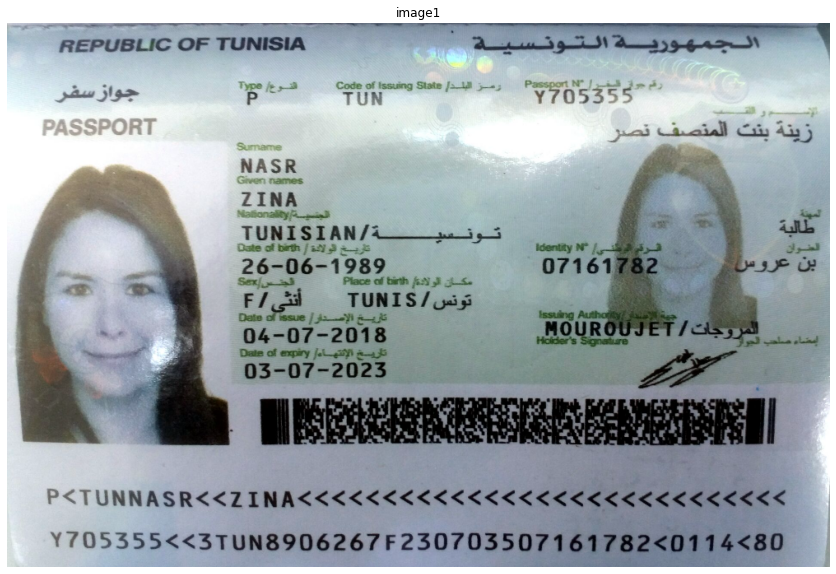

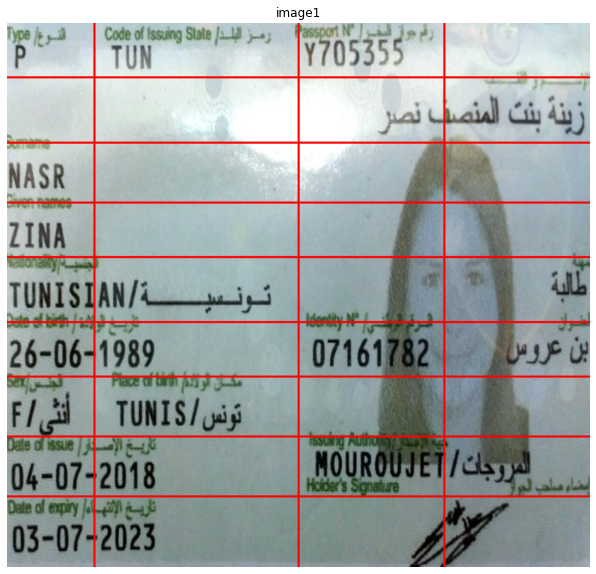

In [24]:
start = time.time()
image = cv2.imread(images[1])
show(image)
(test,test_boxes) = process(image)
end = time.time()
print("elapsed time before ocr: ", end - start)
start = time.time()
object_dict = text_results_easyocr(test,test_boxes)
print("results : " ,json.dumps(object_dict, indent=4,ensure_ascii = False))
print("ocr time : ", time.time() - start)
show(show_grid(test))

In [3]:
image = cv2.imread("testing2.png")
image.shape

(661, 1000, 3)